In [2]:
import pandas as pd
import psycopg2
from sklearn.cluster import KMeans

In [3]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="Root@123",
)
cursor = conn.cursor()

In [4]:
# Define a function to execute SQL queries and return results as a DataFrame
def execute_query(query):
    with conn.cursor() as cursor:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        return pd.DataFrame(cursor.fetchall(), columns=columns)


query = """
 SELECT "MSISDN/Number", "Bearer Id","TCP DL Retrans. Vol (Bytes)", "Avg RTT DL (ms)", "Handset Type", "Avg Bearer TP DL (kbps)"
        FROM public.xdr_data
        """
# Execute query and load data into DataFrame
xdr_data = execute_query(query)
# Check the first few rows of the DataFrame
print(xdr_data.head())

   MSISDN/Number     Bearer Id  TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)  \
0   3.366496e+10  1.311448e+19                          NaN             42.0   
1   3.368185e+10  1.311448e+19                          NaN             65.0   
2   3.376063e+10  1.311448e+19                          NaN              NaN   
3   3.375034e+10  1.311448e+19                          NaN              NaN   
4   3.369980e+10  1.311448e+19                          NaN              NaN   

                  Handset Type  Avg Bearer TP DL (kbps)  
0   Samsung Galaxy A5 Sm-A520F                     23.0  
1  Samsung Galaxy J5 (Sm-J530)                     16.0  
2     Samsung Galaxy A8 (2018)                      6.0  
3                    undefined                     44.0  
4             Samsung Sm-G390F                      6.0  


In [5]:
# Assuming df is your DataFrame containing the dataset
# Replace missing values with the mean or mode of the corresponding variable
xdr_data["TCP DL Retrans. Vol (Bytes)"] = xdr_data["TCP DL Retrans. Vol (Bytes)"].fillna(
    xdr_data["TCP DL Retrans. Vol (Bytes)"].mean()
)
xdr_data["Avg RTT DL (ms)"] = xdr_data["Avg RTT DL (ms)"].fillna(xdr_data["Avg RTT DL (ms)"].mean())
xdr_data["Avg Bearer TP DL (kbps)"] = xdr_data["Avg Bearer TP DL (kbps)"].fillna(
xdr_data["Avg Bearer TP DL (kbps)"].mean()
)
xdr_data["Handset Type"] = xdr_data["Handset Type"].fillna(
    xdr_data["Handset Type"].mode()[0]
)

# Aggregate per customer information
customer_info = (
    xdr_data.groupby("Bearer Id")
    .agg(
        {
            "TCP DL Retrans. Vol (Bytes)": "mean",
            "Avg RTT DL (ms)": "mean",
            "Handset Type": lambda x: x.mode()[0],
            "Avg Bearer TP DL (kbps)": "mean",
        }
    )
    .reset_index()
)

# Now you have the aggregated information per customer

In [6]:
# Task 3.2 - Compute & list 10 of the top, bottom, and most frequent values for TCP, RTT, and Throughput

# Compute top, bottom, and most frequent values for TCP
top_10_TCP = xdr_data["TCP DL Retrans. Vol (Bytes)"].nlargest(10)
bottom_10_TCP = xdr_data["TCP DL Retrans. Vol (Bytes)"].nsmallest(10)
most_frequent_TCP = xdr_data["TCP DL Retrans. Vol (Bytes)"].mode()

# Compute top, bottom, and most frequent values for RTT
top_10_RTT = xdr_data["Avg RTT DL (ms)"].nlargest(10)
bottom_10_RTT = xdr_data["Avg RTT DL (ms)"].nsmallest(10)
most_frequent_RTT = xdr_data["Avg RTT DL (ms)"].mode()

# Compute top, bottom, and most frequent values for Throughput
top_10_Throughput = xdr_data["Avg Bearer TP DL (kbps)"].nlargest(10)
bottom_10_Throughput = xdr_data["Avg Bearer TP DL (kbps)"].nsmallest(10)
most_frequent_Throughput = xdr_data["Avg Bearer TP DL (kbps)"].mode()

# Print the computed values
print("Top 10 TCP values:")
print(top_10_TCP)
print("\nBottom 10 TCP values:")
print(bottom_10_TCP)
print("\nMost frequent TCP value:")
print(most_frequent_TCP)
print("\nTop 10 RTT values:")
print(top_10_RTT)
print("\nBottom 10 RTT values:")
print(bottom_10_RTT)
print("\nMost frequent RTT value:")
print(most_frequent_RTT)
print("\nTop 10 Throughput values:")
print(top_10_Throughput)
print("\nBottom 10 Throughput values:")
print(bottom_10_Throughput)
print("\nMost frequent Throughput value:")
print(most_frequent_Throughput)

Top 10 TCP values:
77979     4.294426e+09
135678    4.291380e+09
34645     4.289877e+09
140813    4.289488e+09
3782      4.288060e+09
119684    4.275259e+09
39637     4.268432e+09
76990     4.259997e+09
59016     4.256650e+09
41209     4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP values:
59717     2.0
125094    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75093     4.0
100314    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most frequent TCP value:
0    2.080991e+07
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Top 10 RTT values:
30166     96923.0
29927     64640.0
17910     55811.0
5989      54847.0
22851     26971.0
23455     26250.0
1373      25873.0
81274     25602.0
97321     25374.0
100584    24733.0
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT values:
42612     0.0
52225     0.0
60152     0.0
61152     0.0
61345     0.0
103328    0.0
124544    0.0
142526    0.0
143878    0.0
71739  

In [17]:
# Task 3.3 - Compute & report the distribution of average throughput per handset type
average_throughput_per_handset = xdr_data.groupby("Handset Type")[
    "Avg Bearer TP DL (kbps)"
].mean()

print("Distribution of Average Throughput per Handset Type:")
print(average_throughput_per_handset)

# Task 3.3 - Compute & report the average TCP retransmission view per handset type
average_TCP_retransmission_per_handset = xdr_data.groupby("Handset Type")[
    "TCP DL Retrans. Vol (Bytes)"
].mean()

print("\nAverage TCP Retransmission View per Handset Type:")
print(average_TCP_retransmission_per_handset)

Distribution of Average Throughput per Handset Type:
Handset Type
A-Link Telecom I. Cubot A5                                                             23184.000000
A-Link Telecom I. Cubot Note Plus                                                       6527.000000
A-Link Telecom I. Cubot Note S                                                          8515.000000
A-Link Telecom I. Cubot Nova                                                           55667.000000
A-Link Telecom I. Cubot Power                                                          69126.000000
                                                                                           ...     
Zte Zte Blade C2 Smartphone Android By Sfr Startrail 4 Zte Blade Flex T809 Zte T809       44.500000
Zyxel Communicat. Lte7460                                                              39741.000000
Zyxel Communicat. Sbg3600                                                              82818.000000
Zyxel Communicat. Zyxel Wah7706   

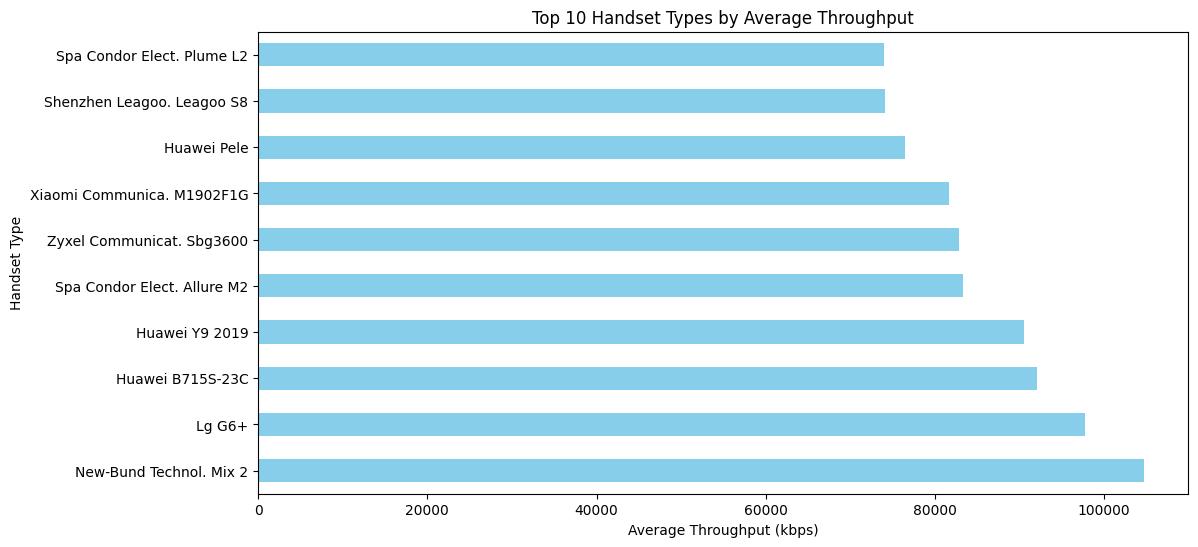

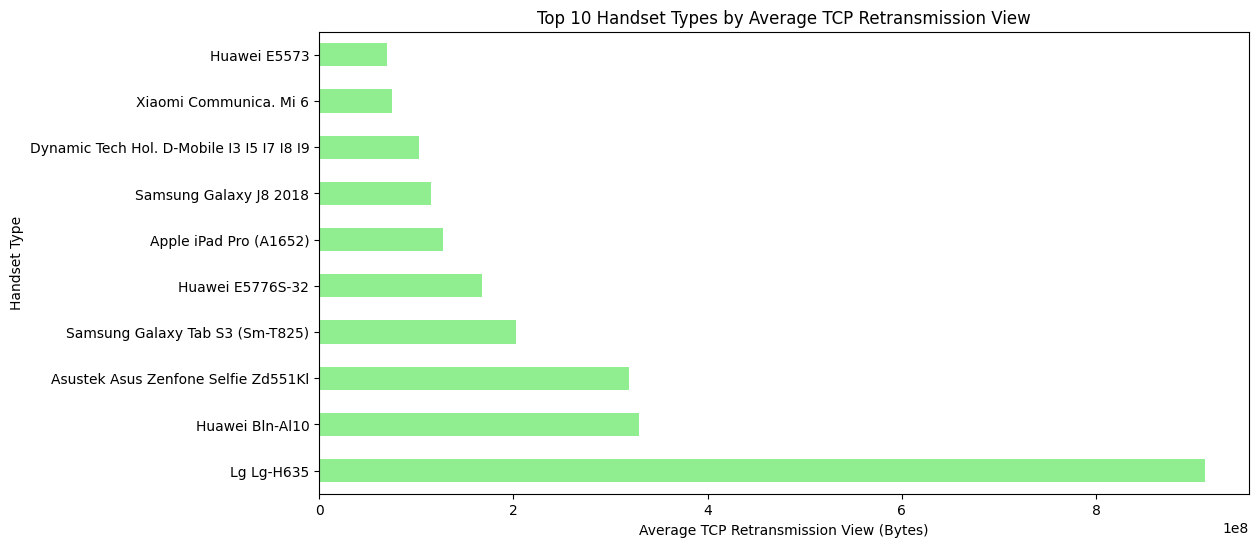

In [18]:
import matplotlib.pyplot as plt

# Top N handset types for average throughput
top_n_throughput = average_throughput_per_handset.nlargest(10)

# Top N handset types for average TCP retransmission view
top_n_TCP_retransmission = average_TCP_retransmission_per_handset.nlargest(10)

# Plotting the top N handset types for average throughput
plt.figure(figsize=(12, 6))
top_n_throughput.plot(kind="barh", color="skyblue")
plt.xlabel("Average Throughput (kbps)")
plt.ylabel("Handset Type")
plt.title("Top 10 Handset Types by Average Throughput")
plt.show()

# Plotting the top N handset types for average TCP retransmission view
plt.figure(figsize=(12, 6))
top_n_TCP_retransmission.plot(kind="barh", color="lightgreen")
plt.xlabel("Average TCP Retransmission View (Bytes)")
plt.ylabel("Handset Type")
plt.title("Top 10 Handset Types by Average TCP Retransmission View")
plt.show()

In [9]:
# Task 3.4 - Perform k-means clustering to segment users into groups of experiences

# Define the features for clustering
features = customer_info[
    ["TCP DL Retrans. Vol (Bytes)", "Avg RTT DL (ms)", "Avg Bearer TP DL (kbps)"]
]

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
customer_info["Cluster"] = kmeans.fit_predict(features)

# Brief description of each cluster
cluster_descriptions = {
    0: "Cluster 0: Users with low TCP retransmission volume, low RTT, and moderate throughput.",
    1: "Cluster 1: Users with high TCP retransmission volume, high RTT, and low throughput.",
    2: "Cluster 2: Users with moderate TCP retransmission volume, moderate RTT, and high throughput.",
}

# Print cluster descriptions
print("Cluster Descriptions:")
for cluster, description in cluster_descriptions.items():
    print(description)

# Print the count of users in each cluster
print("\nNumber of Users in Each Cluster:")
print(customer_info["Cluster"].value_counts())

Cluster Descriptions:
Cluster 0: Users with low TCP retransmission volume, low RTT, and moderate throughput.
Cluster 1: Users with high TCP retransmission volume, high RTT, and low throughput.
Cluster 2: Users with moderate TCP retransmission volume, moderate RTT, and high throughput.

Number of Users in Each Cluster:
Cluster
0    134371
2       240
1        97
Name: count, dtype: int64


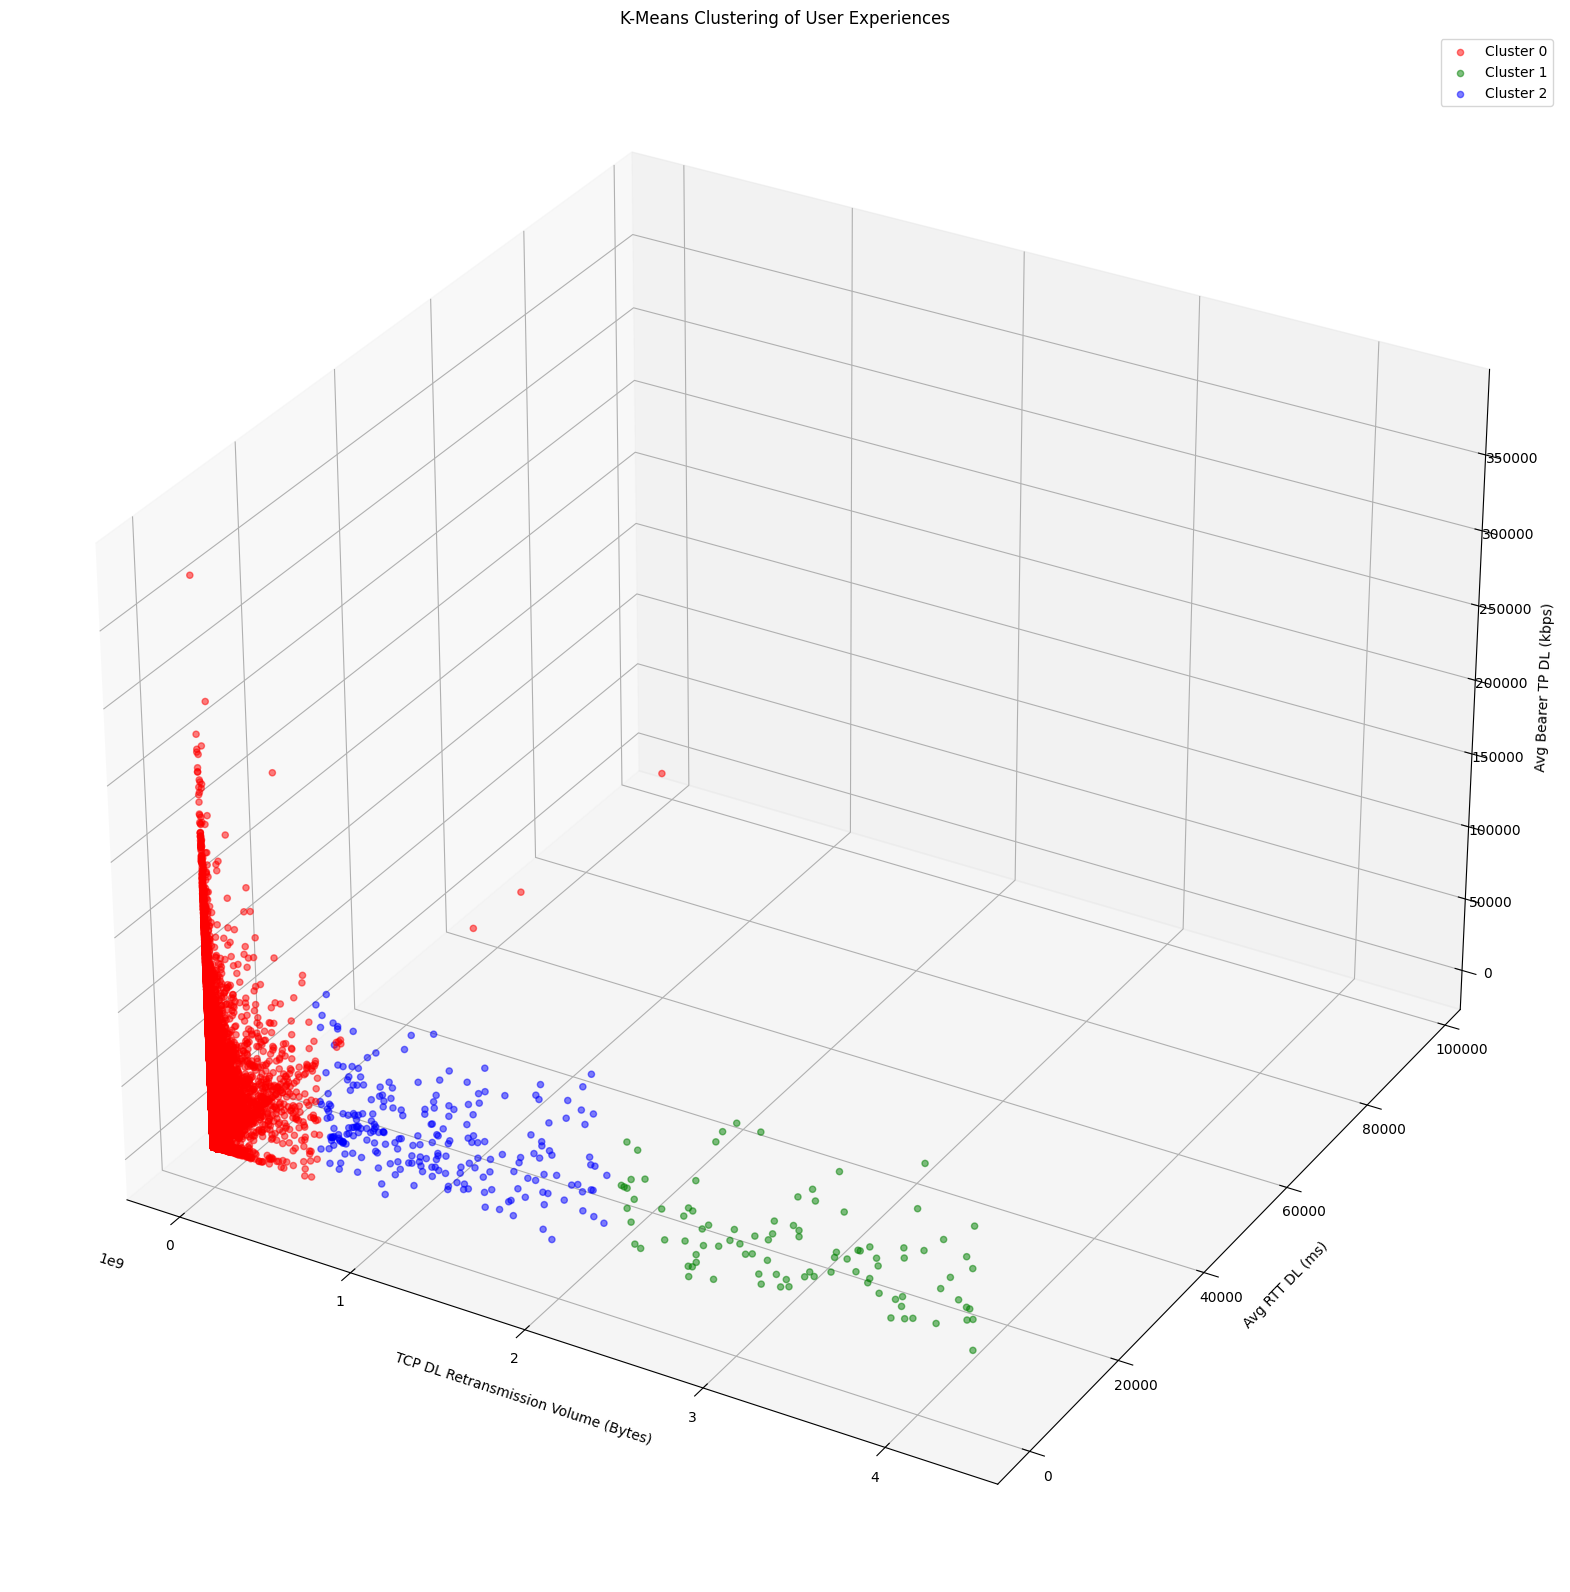

In [40]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(20, 60))
ax = fig.add_subplot(111, projection="3d")

# Define colors for each cluster
colors = ["r", "g", "b"]

# Plot each cluster
for cluster in range(3):
    cluster_data = customer_info[customer_info["Cluster"] == cluster]
    ax.scatter(
        cluster_data["TCP DL Retrans. Vol (Bytes)"],
        cluster_data["Avg RTT DL (ms)"],
        cluster_data["Avg Bearer TP DL (kbps)"],
        c=colors[cluster],
        label=f"Cluster {cluster}",
        alpha=0.5,
    )

# Set labels and title
ax.set_xlabel("TCP DL Retransmission Volume (Bytes)", labelpad=10)
ax.set_ylabel("Avg RTT DL (ms)", labelpad=10)
ax.set_zlabel("Avg Bearer TP DL (kbps)", labelpad=10)
ax.set_title("K-Means Clustering of User Experiences")

# Add a legend
ax.legend()

# Show plot
plt.show()